In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn
import copy
import seaborn as sns
import sklearn
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
import lightgbm as lgb

# fix seed to make results reproducible
seed = 42

This notebook implements numerous classifiers for the UCI cardiotocography data set.

# Introduction
Cardiotocography (CTG) is a technique to record fetal heartbeat and uterine contractions during pregnancy. It is typically used in the third trimester, in which the fetus is prone to sudden drops in oxygen supply (hypoxia). This can lead to death and long-term disability. Based on CTG data, doctors decide whether to perform an intervention, such as a Caesarian section. Doctors typically look at CTG results that have already gone through a signal processing algorithm, and make their decision based on this summary and their medical expertise. 

In this notebook, we aim to predict fetal health status from raw CTG data. The proposed predictive model can help doctors' decision process by providing a simple binary classification of the fetus' status: normal or suspect/pathological. The goal of this study is therefore not to automate diagnosis but to provide an additional piece of information that might prevent doctors from prescribing unnecessary C-sections or, even worse, fail to intervene when the fetus is in distress.

The notebook implements and gives a brief theoretical overview over different classifiers, including elastic-net penalized logistic regression, support vector machines (SVM), random forests, and boosted decision trees. It also discusses the 'proper' way to do cross-validation and touches upon how to deal with imbalanced data. Finally, I present stacking the different proposed models as a way to optimize performance in this high-stakes predictive problem.

# Data
The CTG data set is publicly available from the UCI Machine Learning repository. The data contains the diagnostic features of 2126 fetal cardiotocograms. The data also contains classification labels assigned by expert obstetricians, who classify 1655 cases as normal, 295 cases as suspicious and 176 cases as pathologic. Here is a first look at the data:

In [2]:
# Read data
df = pd.read_excel('CTG.xls', header=0, sheet_name=2, skipfooter=3)
df.dropna(axis=0, thresh=10, inplace=True) # drop empty rows from the original xls file

# drop irrelevant and classification columns
df.drop(columns=['FileName', 'Date', 'SegFile', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP','CLASS', 'DR',], inplace=True)
df

,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
1,240.0,357.0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
2,5.0,632.0,132.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
3,177.0,779.0,133.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
4,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
5,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122,2059.0,2867.0,140.0,140.0,0.0,0.0,6.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2123,1576.0,2867.0,140.0,140.0,1.0,0.0,9.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2124,1576.0,2596.0,140.0,140.0,1.0,0.0,7.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2125,1576.0,3049.0,140.0,140.0,1.0,0.0,9.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


First, we transform the three-class expert classification (variable 'NSP') to only two classes, normal and suspect/pathologic. This is in line with the idea of an algorithm that can quickly alert doctors to take a second look at their decision, rather than produce a full diagnosis. It also has the advantage of making this a binary classification problem, which is in many ways easier to deal with. The resulting class distribution is considerably imbalanced, with $77.8$ percent of observations belonging to the normal class.

[Text(-1, 0, 'normal'), Text(1, 0, 'suspect/pathologic')]

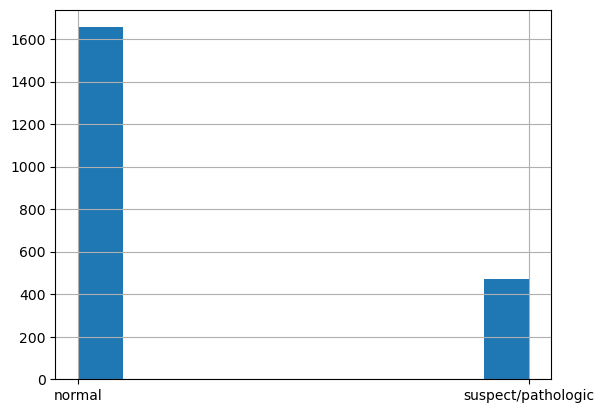

In [3]:
# Make binary outcome variable (normal,suspect+pathological)
df['status'] = np.where(df.NSP == 1, -1, 1)  # recodes normal to -1 and everything else to 1

# Plot histogram
fig, ax = plt.subplots(1,1)
df.status.hist()
class_names = ['normal', 'suspect/pathologic']
ax.set_xticks([-1,1])
ax.set_xticklabels(class_names)

We can also take a look at the distribution of our 24 diagnostic features:

C:\Users\prana\AppData\Local\Temp\ipykernel_13224\3214354978.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_X.hist(ax=ax)


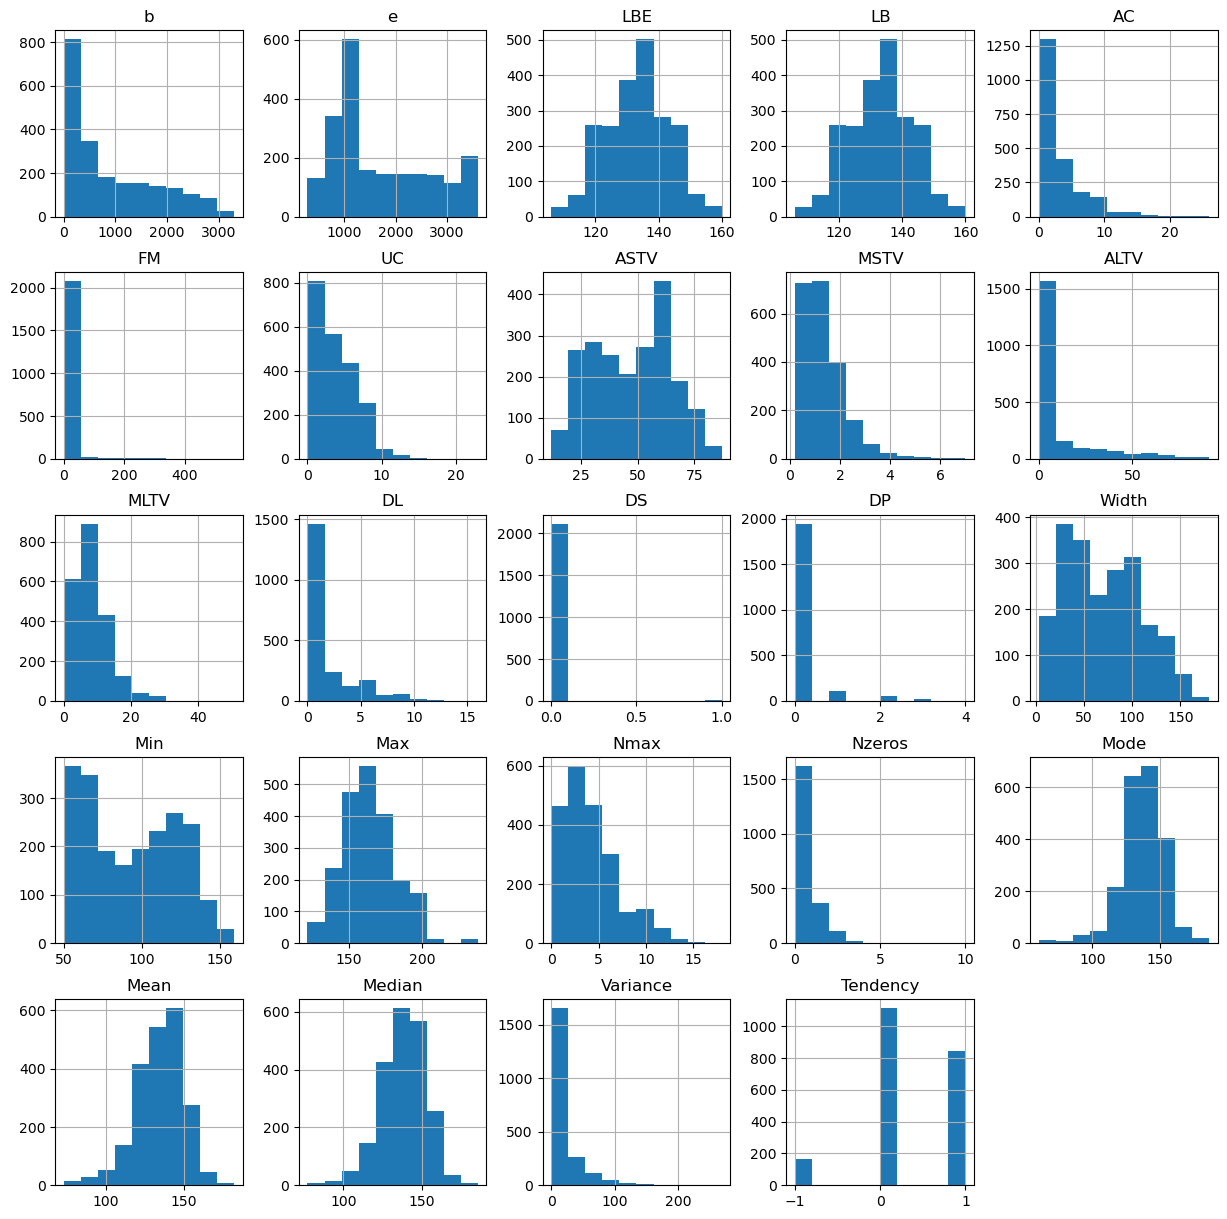

In [4]:
# Histogram for all features
df_X = df.drop(columns=['NSP', 'status'])
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
df_X.hist(ax=ax)
plt.show()

In [5]:
print('Number of missing values: ', df.isnull().sum().sum())  # check for missing

Number of missing values:  0


Fortunately, we have no missing values in this data set. However, an important problem in medical monitoring is measurement error. Let's make a scaled boxplot of our features:

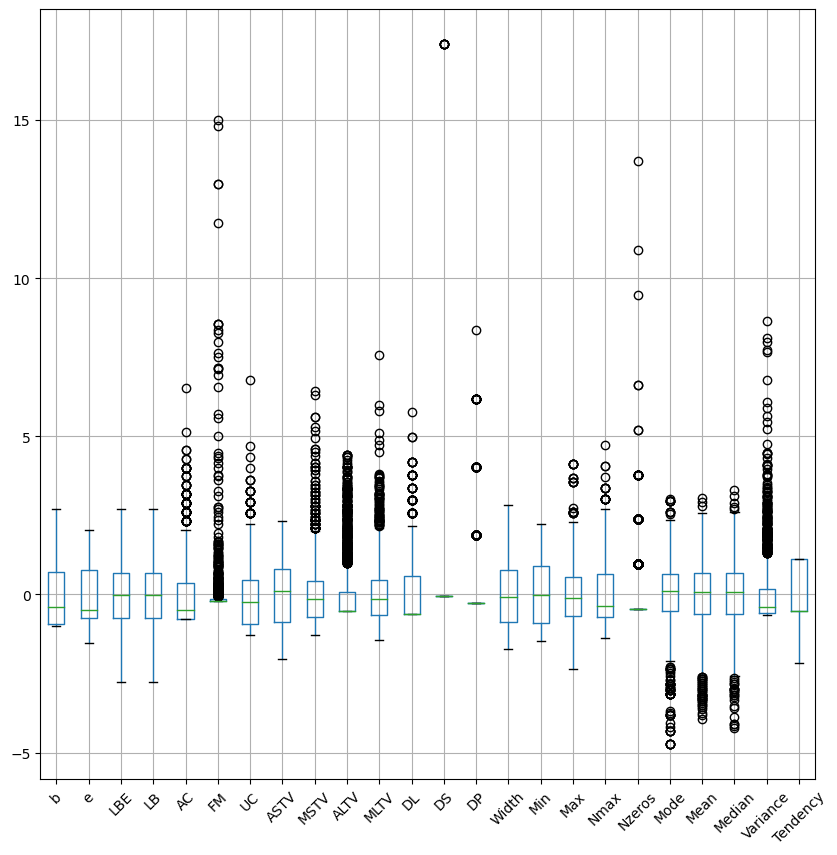

In [6]:
# Boxplots for feature distributions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_scale_X = pd.DataFrame(sklearn.preprocessing.scale(df_X), columns=df_X.columns)
df_scale_X.boxplot(ax=ax, rot=45)
plt.show()

As we can see, there are quite a few observations where a feature value is more than five standard deviations away from the feature mean. These outliers might represent instrument error; but they might also be caused by fat-tails of the true distributions, in which case these values are informative. If the outliers are errors, this can negatively impact the performance of our classifiers. We will discuss outlier detection algorithms and their impact on performance later.

We can also take a look at feature cross-correlation and their correlation with the outcome variable fetal status:

C:\Users\prana\AppData\Local\Temp\ipykernel_13224\1994960769.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corr = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool)) # make heatmap lower triangular (remove redundant info)


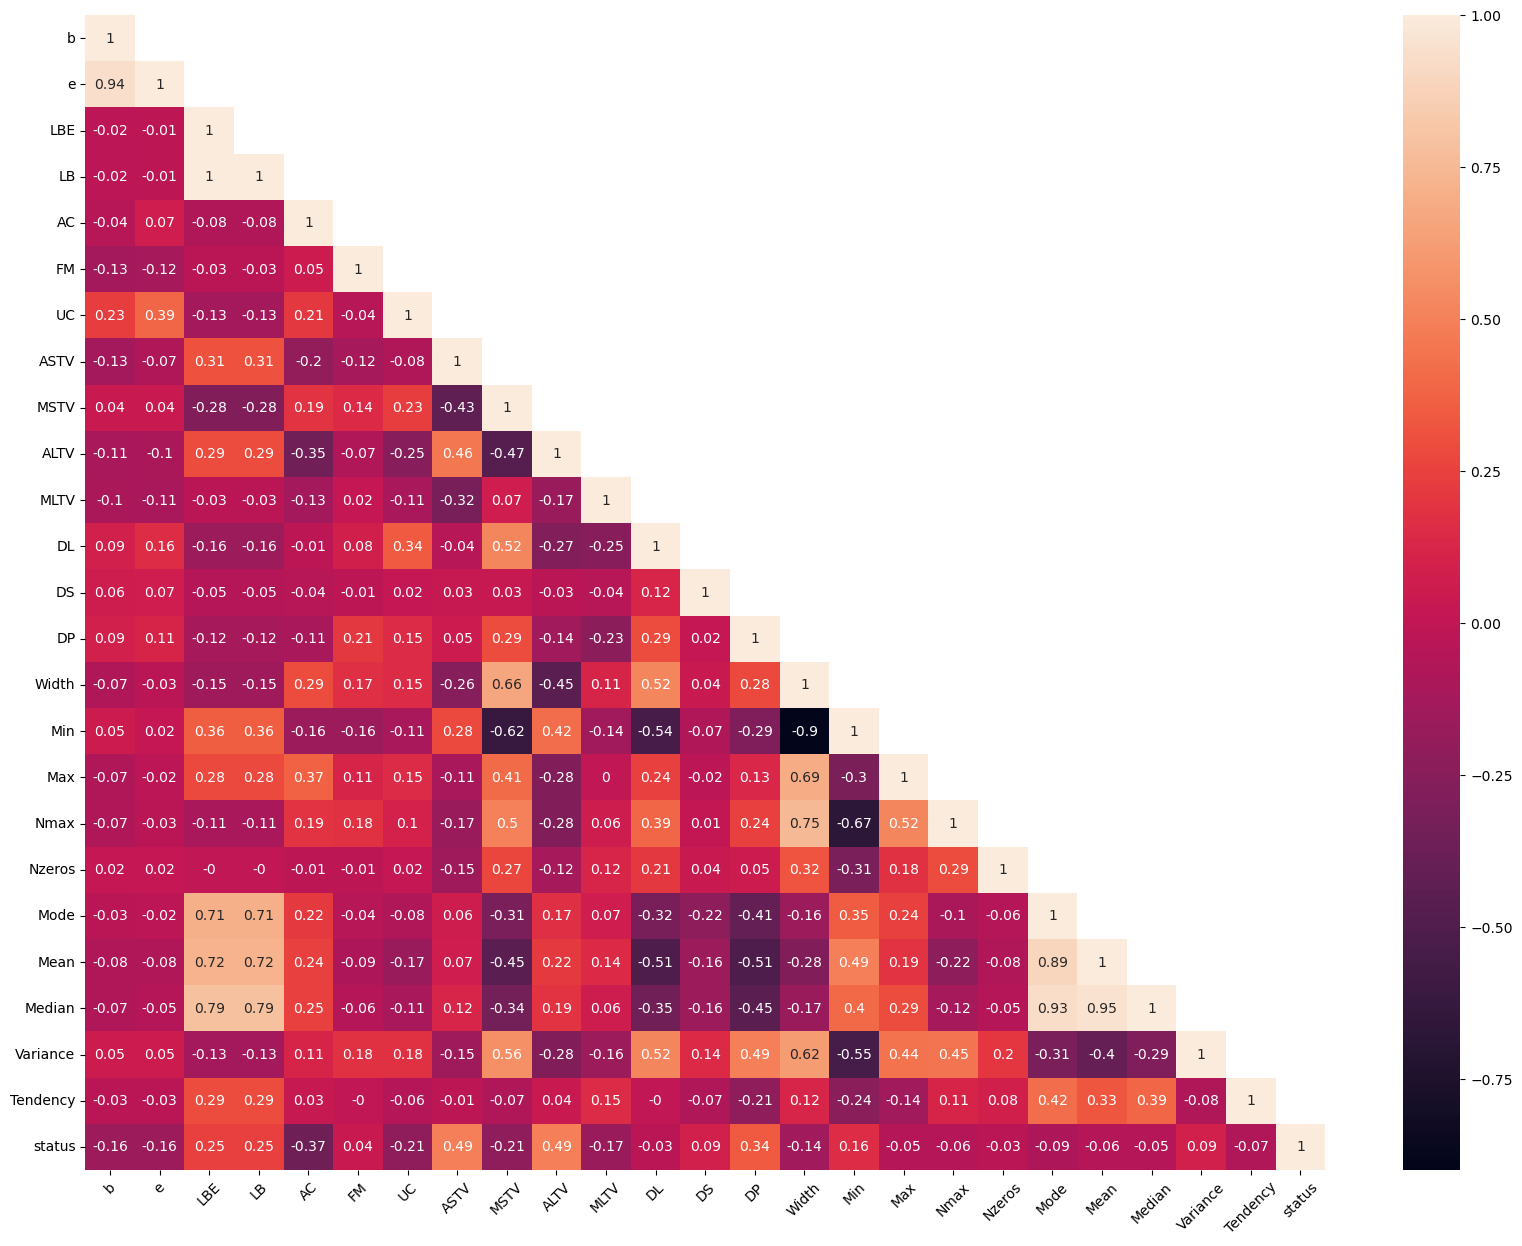

In [7]:
# Feature correlation heatmap
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
corr = df.drop(columns=['NSP']).corr()
corr = corr.round(decimals=2)
corr = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool)) # make heatmap lower triangular (remove redundant info)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax)
plt.xticks(rotation=45)
plt.show()

Some features exhibit significant cross-correlation (both negative and positive); however, we never have exact multicollinearity. Some variables, such as the number of heartrate accelerations ('AC') and uterine contractions ('UC'), correlate positively with normal fetal status (which is coded as -1); while others, such as abnormal long and short term availability ('ALTV' and 'ASTV') and the number of prolongued heartrate deccelerations ('DP') correlate negatively, meaning higher values occur more frequently with suspect/pathological fetal status (coded as 1). Some of these correlations are substantial but there are no variables with absolute correlation coefficient above 0.5, indicating that no single feature alone can provide good predictions.

Next, we construct our feature matrix $\mathbf{X}$ and vector of labels $\mathbf{y}$. Before we do this, we shuffle the data once (with fixed seed to make results reproducible) in order to break up any inherent order the observations might have. This is important to get accuracte approximations of out-of-sample performance with cross-validation. 

In [8]:
# shuffle data
df = df.sample(frac=1, random_state=seed)

# make vector of class labels and feature matrix
y, X = df.status.values, df.drop(columns=['NSP', 'status']).values.astype('float')

# Outlier treatment
To deal with the potential problem of measurement error outlined previously, we simply flag feature values with absolute z-scores above a threshold value $z_{\text{crit}}$ as errors. The errors are then treated as missing values and imputed via a k-Nearest Neighbors approach. Specifically, a missing feature value of a given observations is imputed as the average value of that feature of the 5 nearest neighbors, where nearest neighbors are observations closest in terms of euclidean distance of the feature matrix. 

In [9]:
def zscore_outlier_removal(X, threshold=100):
    """ Sets feature values in X that are more than (threshold * feature standard deviation) away from feature mean
    to NaN. Returns X with original length but some column values are NaN. At default value 100, no outlier treatment occurs.
    """
    new_X = copy.deepcopy(X)
    new_X[abs(sklearn.preprocessing.scale(X)) > threshold] = np.nan

    return new_X

# Make zscore feature outlier removal a transformer function
zscore_outlier_removal = sklearn.preprocessing.FunctionTransformer(zscore_outlier_removal,
    kw_args=dict(threshold=7))


# Replace feature outliers with imputed values via KNN
KNN_impute = KNNImputer()

For some of the classifiers we want to implement, we also need to scale the feature matrix; and we might want to perform a polynomial expansion of features:

In [10]:
# Polynomial feature expansion
poly = sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# demean and scale to unit variance
scale = sklearn.preprocessing.StandardScaler()

# Model selection and the 'proper' way to cross-validate
Before we dive into different classification algorithms, I want to discuss how we can objectively compare model performance. We train the models on the data set at hand, but our goal is to get accurate predictions for $\textit{new}$ patients who receive a cardiotocography. We therefore need to test how our models would generalize to new data of the same format. In practice, we do this via stratified k-fold cross-validation. The data is divided into $k$ bins ('folds'). The folds are stratified in the sense of preserving class distribution in each fold. Each fold is used once as a test set for a model trained on the $k-1$ other folds. The technique therefore serves to get an approximation of out-of-sample performance.

We also have to choose a metric for model performance. This should really depend on the costs of a false positive (i.e. an unnecessary C-section) relative to the cost of a false negative (i.e. failing to intervene when the fetus is in distress). Let's be agnostic and simply take the two errors to be equally bad. An appropriate metric is then balanced accuracy. Balanced accuracy is simply the equally weighted average of accuracy in each class. This measure will not be inflated by imbalanced class prevalence and takes into account our assumption that misclassifications are equally bad for both classes. We also apply this to classifiers themselves: all classifiers are fitted using sample weights that weight observations by their inverse class prevalence. This means that errors for both classes are equally weighted, irrespective of class prevalence.

An important thing to remember when comparing models via cross-validation is to include all pre-processing steps as part of the model pipeline that will be fit only on training data in the respective fold. Let's say we want to apply outlier treatment and feature scaling before applying a SVM classifier. The model pipeline then consists of outlier treatment and scaling, followed by the SVM classifier. At each fold, the whole pipeline needs to be fit to the training data and then evaluated on the test set. This means that the feature means and variances to calculate z-scores and perform scaling is based on the feature distributions in the training set and never the test set. Note that if we would simply preprocess the whole data set before doing cross-validation, we would use information from outside the training set for our predictive model. This is called leakage and can cause inflated out-of-sample scores.

To compare models, we introduce the following function:

In [11]:
def print_cv(cv, X, y, model_name):
    """ Prints best score, best parameter values, and in and out of sample confusion matrices for a cv
    result """
    print('Results for {}:'.format(model_name))
    print('The best out-of-sample performance is {}'.format(cv.best_score_))
    print('Best parameter values: ', cv.best_params_)

    pred = cv.best_estimator_.predict(X)
    print('In-sample confusion matrix of best estimator:\n{}'.format(sklearn.metrics.confusion_matrix(y, pred)))

    cross_val_pred = sklearn.model_selection.cross_val_predict(cv.best_estimator_, X, y, cv=5, n_jobs=-1)
    print('Out-of-sample confusion matrix of best estimator:\n{}'.format(
        sklearn.metrics.confusion_matrix(y, cross_val_pred)))

    return

# SVM
We are now ready to do some classification. The first classifier we will use is a support vector machine (SVM). Before we apply SVM,we map the input features into a higher-dimensional space using a kernel function. We consider two kernels, Gaussian and polynomial. For the Gaussian kernel, the elements of the kernel matrix $\mathbf{K}$ are given by $k_{ij} = \exp(\gamma||\mathbf{X}_i - \mathbf{X}_j||^2)$, where we fix the scale parameter $\gamma$ to $1/p$ and $p$ the number of features. For the (inhomogenous) polynomial kernel of degree $d$, we have $k_{ij} = (1 + \mathbf{X}_i^T\mathbf{X}_j)^d$.

The SVM algorithm now constructs an optimal linear decision surface in the higher-dimensional space of the kernel matrix. Predicted values $q_i$ are simply constructed as linear combinations of the predictors: $q_i=c + \sum_{j=1}^p x_{ij}w_j$, where $c$ is an intercept and $\mathbf{w}$ is a vector of predictor weights. We will in the following assume that the two classes in the binary classification problem are coded as $-1$ and $1$. Let $G_{-1}$ and $G_{+1}$ denote the set of indices $i$ where $y_i=-1$ or $y_i=1$, respectively. The loss function of the binary SVM is then given by

\begin{gather*}
    L_{SVM}(c,w) = \sum_{i \in G_{-1}} \max(0,q_i+1) + \sum_{i \in G_{+1}} \max(0,1-q_i) + \lambda \mathbf{w}' \mathbf{w}.
\end{gather*}

The loss function consists of the so-called hinge error for both classes, as well as a penalty $\lambda$ on the size of the weights. Due to the shape of the hinge error, the error is $0$ for most observations. In order to determine the optimal intercept and weights, the only relevant observations are those with non-zero error (these observations form the so-called support vector). The advantage of this method is that it is very fast to compute predictions, and due to the penalization on weights the model can generalize well to new data.

Let's now define an SVM classifier from the skicit-learn package. Note that we specify balanced class weights.

In [12]:
# Support Vector Machine
svm = sklearn.svm.SVC(C=1, kernel='rbf', gamma='scale', class_weight='balanced', probability=True,
    decision_function_shape='ovr')

We then construct a model pipeline consisting of the z-score based outlier removal, followed by KNN imputation, scaling, and the final SVM classifier:

In [13]:
svm_pipe = sklearn.pipeline.Pipeline(
    [('outlier', zscore_outlier_removal), ('impute', KNN_impute), ('scale', scale), ('svm', svm)])

We now want to tune the hyperparameters of our predictive model to optimize out-of-sample performance. We want to try a number of different threshold values for the outlier treatment, Gaussian and polynomial (degree 1,2, and 3) kernels, and a range of penalty values.

In [14]:
# values to try for cross-validation
zscore_threshold_vals = [100, 9, 8, 7, 6, 5, 4, 3]  # 100 = no outlier treatment
kernels = ['rbf', 'poly']
poly_degrees = [1, 2, 3] # degrees of polynomial expansion (only relevant for polynomial kernel)
penalty_vals = [np.e ** i for i in np.linspace(-3, 3, 8)]

We now choose the optimal values via 5-fold cross-validation. Since the parameter space to search over quickly becomes very large, it is advisable to optimize only over a subset of parameters at a time when the interaction between those parameters that are left out and those that we optimize over is small. For instance, the outlier threshold only affects few observations and therefore has a negligible effect on the optimal penaty or kernel. On the other hand, for SVM, the kernel function determines the dimension of the space that the optimal separating hyperplane is constructed in. Therefore we can expect the kernel type to have an important effect on the optimal penalty. We therefore start by optimizing kernel type and penalty together:

In [15]:
# kernel and penalty search
svm_grid = {"svm__C": penalty_vals, "svm__kernel": kernels, "svm__degree": poly_degrees}

svm_cv = sklearn.model_selection.GridSearchCV(svm_pipe, svm_grid, scoring='balanced_accuracy', n_jobs=-1,
    refit=True, verbose=True, return_train_score=True, cv=5)
svm_cv.fit(X, y)
print_cv(svm_cv, X, y, 'support vector machine')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Results for support vector machine:
The best out-of-sample performance is 0.9345516149440259
Best parameter values:  {'svm__C': 20.085536923187664, 'svm__degree': 1, 'svm__kernel': 'rbf'}
In-sample confusion matrix of best estimator:
[[1614   41]
 [   0  471]]
Out-of-sample confusion matrix of best estimator:
[[1586   69]
 [  42  429]]


The best performance is achieved with a Gaussiand kernel and a penalty around 20, leading to out-of-sample balanced accuracy of over 93.4 percent!

# Decision trees
The next two methods will use decision trees as their base classifiers. Let's just briefly recap what decision trees are. Decision trees consist of a series of splitting rules (which constitute 'nodes') along a feature and a given cutoff. The final predictions depend on which terminal node ('leaf') an observation ends up in when descending through the tree. Below I plotted an example of a decision tree for the data at hand:

![](https://github.com/jakob-ra/Cardiotocography/raw/master/tree.png)

We start with the full sample (2126 observations) at node $0$. Now, a split occurs according to whether the 'ASTV' variable is lower than $59.5$ and the observations are send to two child nodes accordingly. Another two splits occur at nodes $1$ and $4$ and we are left with four leafs. At each leaf, the final prediction is simply the majority class of observations at that leaf: suspect/pathological at nodes $2$ and $5$ and normal at nodes $3$ and $6$. Now, how to find the best splitting rule? At each node, we can choose a feature and a threshold to split on. At each node, we choose the splitting rule that leads to the largest decrease in Gini impurity: $G=1-p_{-1}^2-p_{+1}^2 $, wheree $p_{-1}$ and $p_{+1}$ are the shares of class $-1$ and $1$, respecively. We also need to specify some stopping criterion: we will simply set a maximum depth of the tree (the largest distance between the root and a leaf)

# Random forests
Random forests are a combination of boostrap aggregating ('bagging') and random feature subspaces for decision trees. Bagging is an ensemble method that constructs a number of different training sets by sampling observations with replacement from the original set (this is called a bootstrap). We then fit a base classifier to each bootstrapped training set and aggregate the predictions of each classifier (by averaging them for regression problems or taking the majority vote for classification). This method of creating an ensemble of classifiers usually leads to more robust performance, especially when the variance and likelihood of overfitting of the base classifier is high. These issues are very pronounced for decision trees, which is why they are usually employed in ensembles ('forests'). Bagged trees are called random forest when each tree is fit to a random subset of the features. This leads to greater differences between individual trees, making the ensemble more powerful.

We now define a random forest classifier: 

In [16]:
random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=2,
    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=10,
    bootstrap=True, oob_score=False, n_jobs=-1, random_state=seed, class_weight='balanced')


Decision trees do not need scaled features. For this classifier, I also choose not to implement outlier treatment or polynomial expansion of features. We therefore do not need to define a pre-processing pipeline. The hyperparameters I want to tune over is the maximum depth of the base classification tree, the number of trees in the ensemble, and the number of features that are randomly selected for each tree.

In [17]:
# values for cross-validation
tree_numbers = [20, 50, 100, 200]
tree_depths = [1, 2, 3, 4, 5, 6, 7, 8]
max_feature_vals = [3, 5, 8, 10, 15]

random_forest_grid = {"n_estimators": tree_numbers,
    "max_depth": tree_depths,
    "max_features": max_feature_vals}

random_forest_cv = sklearn.model_selection.GridSearchCV(random_forest, random_forest_grid,
    scoring='balanced_accuracy', n_jobs=-1, refit=True, verbose=True, return_train_score=True, cv=5)
random_forest_cv.fit(X,y)

print_cv(random_forest_cv, X, y, 'Random forest')

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Results for Random forest:
The best out-of-sample performance is 0.938162478897636
Best parameter values:  {'max_depth': 7, 'max_features': 15, 'n_estimators': 20}
In-sample confusion matrix of best estimator:
[[1631   24]
 [  10  461]]
Out-of-sample confusion matrix of best estimator:
[[1612   43]
 [  46  425]]


The optimal performance is achieved for an ensemble of 50 trees, maximum tree depth 5, and 10 random features selected for each tree. This leads to an out-of sample balanced accuracy of 93.9 percent, slightly better than the performance of our SVM classifier.

# AdaBoost
Let's now try another ensemble method known as gradient boosting. A special case of this is the popular AdaBoost algorithm. Let us look at how AdaBoost works: We first set a number of maximum iterations $M$ and initialize a vector of equal observation weights $\mathbf{w}$, i.e. $w_i=1/N$ and $N$ the number of observations for $i=1,2,...,N$. We now start iterating from $m=1$ to $m=M$. At each step, we fit a base classifier $G_m(X)$ (e.g. a single decision tree) to the data using observation weights $\mathbf{w}$. We then compute the weighted error rate 
\begin{gather*}
    \text{err}_m=\frac{\sum_{i=1}^N w_i 1_{y_i=G_m(x_i)}}{\sum_{i=1}^{N} w_i},
\end{gather*}
from which we calculate the 'step weight' $\alpha_m= \nu \log((1-\text{err}_m)/\text{err}_m)$, where $\nu \in (0,1)$ is a learning rate parameter. We then set new weights (for the next step) according to $w_i=w_i \exp(\alpha_m 1_{y_i=G_m(x_i)})$ and finally normalize the weights to sum up to one. This concludes the step, and we repeat until we have reached the maximum number of iterations $M$. The final output of the classifier is simply the majority of classifiers at each step, weighted by step weight: $G(\mathbf{X})=\text{sign}\sum_{i=1}^M \alpha_m G_m(\mathbf{X})$.

This method has been proven to be quite powerful. The intuition for why it works is that at each iteration, training observations are re-weighted by the performance of the current classifier: observations where the current classifier does poorly receive more weight in the next step and vice-versa. This induces the weak learners to gradually improve, and the weighted ensemble performs better the more iterations we perform. The learning rate $\nu$ leads to slower learning but can prevent overfitting and lead to a more robust out-of-sample performance.

Let's see how this method does on our problem:

In [18]:
gbm = lgb.LGBMClassifier(max_depth=5, class_weight='balanced',
                        learning_rate=1, n_estimators=500, random_state=seed)

# values to try for cross-validation
learning_rates = [0.01,0.1,1]
n_iterations_vals = [50,200,1000]
tree_depths = [1,2,4,8,16]

gbm_grid = {"max_depth": tree_depths, 
            "learning_rate": learning_rates, 
            "n_estimators": n_iterations_vals}

# stratified 5-fold cross-validation
cv_boost = sklearn.model_selection.GridSearchCV(gbm, gbm_grid, scoring='balanced_accuracy',
    n_jobs=-1, refit=True, verbose=True, return_train_score=False, cv=5)
cv_boost.fit(X,y)

print_cv(cv_boost, X, y, 'AdaBoost')

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Results for AdaBoost:
The best out-of-sample performance is 0.9514025502143222
Best parameter values:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
In-sample confusion matrix of best estimator:
[[1627   28]
 [   1  470]]
Out-of-sample confusion matrix of best estimator:
[[1596   59]
 [  29  442]]


Boosting gives us over 95 percent balanced out-of-sample accuracy! The best hyperparameters are a maximum tree depth of 4, a learning rate of 0.01, and 1000 iterations.

# Stacking
We have seen three different predictive models: SVM with pre-processing in form of outlier treatment and scaling, as well as two tree ensemble methods, random forests and boosted trees. To get even better predictive performance, we might consider combining the predictions from each model. This is especially promising if the individual classifiers use different information to form their predictions. An easy way to combine models is a simple majority vote.

This is quickly implemented:

In [19]:
models = [('forest', random_forest_cv.best_estimator_), ('svm', svm_cv.best_estimator_),
    ('boost', cv_boost.best_estimator_)]

vote_clf = sklearn.ensemble.VotingClassifier(models)

# CV
vote_cv = sklearn.model_selection.GridSearchCV(vote_clf, {}, scoring='balanced_accuracy', n_jobs=-1, refit=True, cv=5)
vote_cv.fit(X,y)
print_cv(vote_cv, X, y, 'Voting ensemble')

Results for Voting ensemble:
The best out-of-sample performance is 0.948342834330797
Best parameter values:  {}
In-sample confusion matrix of best estimator:
[[1632   23]
 [   1  470]]
Out-of-sample confusion matrix of best estimator:
[[1607   48]
 [  35  436]]


Unfortunately, the voting ensemble performs worse than our best classifier, the boosted tree ensemble. A better way to combine models is known as 'stacking'. 

In [20]:
stack = sklearn.ensemble.StackingClassifier(models, cv=5, stack_method='auto')

# CV
stack_cv = sklearn.model_selection.GridSearchCV(stack, {}, scoring='balanced_accuracy', n_jobs=-1, refit=True, cv=5)
stack_cv.fit(X,y)
print_cv(stack_cv, X, y, 'stacking ensemble')

Results for stacking ensemble:
The best out-of-sample performance is 0.9425848238904131
Best parameter values:  {}
In-sample confusion matrix of best estimator:
[[1640   15]
 [   2  469]]
Out-of-sample confusion matrix of best estimator:
[[1616   39]
 [  44  427]]
